# Scaling mpol, ntor reolution of VMEC boundary by [2,4,6] for stage one optimization

In [1]:
import os
from pathlib import Path
from simsopt._core.optimizable import load
import matplotlib.pyplot as plt
import numpy as np
from simsopt.geo import SurfaceRZFourier
from simsopt.mhd import Vmec, QuasisymmetryRatioResidual
from simsopt.field import compute_fieldlines, LevelsetStoppingCriterion, SurfaceClassifier, plot_poincare_data
import pickle
%matplotlib widget

In [17]:
# Load data
date = ['2023-10-18T15:03:14', '2023-10-18T22:51:12', '2023-10-19T11:35:49']
directory = ['runs/' + d for d in date]
parent_path = '.'
this_path = [os.path.join(parent_path, dir) for dir in directory]
vmec_dir = [os.path.join(tp, "vmec") for tp in this_path]
coil_dir = [os.path.join(tp, "coils") for tp in this_path]
figure_path = os.path.join(parent_path, 'figures/stage_one_boundary_resolution_scan')
os.makedirs(figure_path, exist_ok=True)

wout_file = [os.path.join(tp, "wout_final.nc") for tp in this_path]
vmec = [Vmec( wout ) for wout in wout_file]
initial_vmec = Vmec( 'wout_vacuum_cssc_scaled.nc' ) 
initial_bs = load( 'flux_100_bs_cssc_cssc.json' )
bs = [load(os.path.join(tp,"coils/bs_output.json")) for tp in this_path]

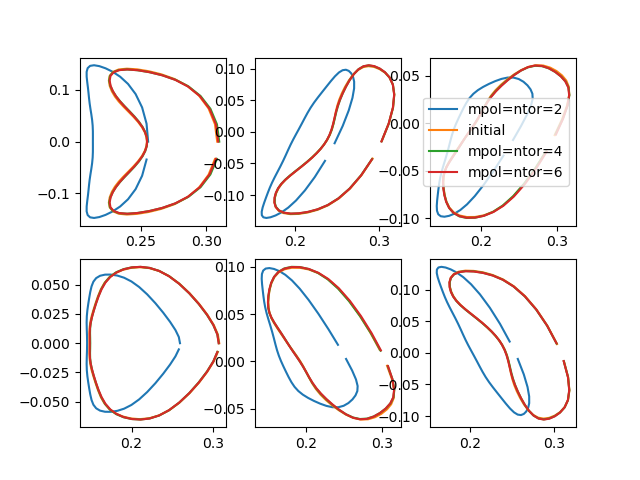

In [56]:
# Plots cross-sections
fig, ax = plt.subplots(2,3)
varr = [initial_vmec] + vmec
leg = {'initial', 'mpol=ntor=2', 'mpol=ntor=4', 'mpol=ntor=6'}
for phi, aa in zip(np.linspace(0,np.pi,6,endpoint=False), ax.flatten()):
    for v in varr:
        s = v.boundary
        c = s.cross_section(phi=phi)

        R = np.sqrt(c[:,0]**2 + c[:,1]**2)
        Z = c[:,2]

        aa.plot(R,Z)
ax[0,2].legend(leg)
plt.savefig(os.path.join(figure_path, 'boundary_cross_section.png'))

In [37]:
outputs = []
inputs = []
for tp in this_path:
    with open(os.path.join(tp, 'outputs.pckl'), 'rb') as f:
        outputs.append(pickle.load(f))
    with open(os.path.join(tp, 'input.pckl'), 'rb') as f:
        inputs.append(pickle.load(f))

'float' object has no attribute 'reshape'
'float' object has no attribute 'reshape'
'float' object has no attribute 'reshape'
'float' object has no attribute 'reshape'
'float' object has no attribute 'reshape'
'float' object has no attribute 'reshape'


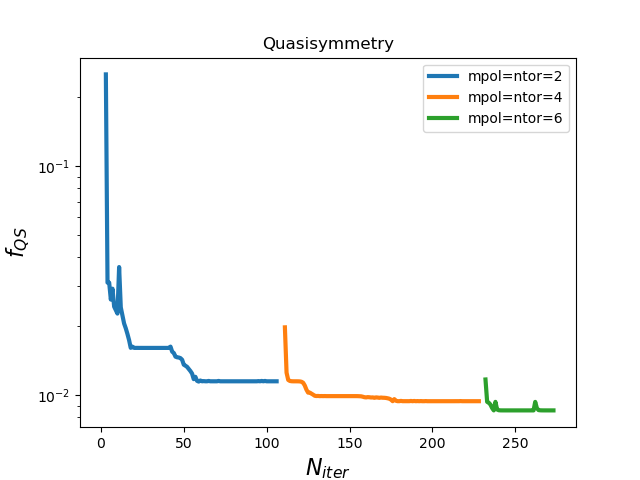

In [53]:
total = []
step = []
nphi = 64
ntheta = 63
counter = 0
for jj, (inp, oup) in enumerate(zip(inputs, outputs)):
    total.append([])
    step.append([])
    nsteps = len(oup['mean_iota'])
    ns = inp['vmec']['target']['qa_surface'].size
    for ii, qs in enumerate(oup['QSresiduals']):
        counter +=1
        try:
            residuals3d = qs.reshape((ns,ntheta,nphi))
            total[jj].append(np.sum(qs * qs))
        except BaseException as e:
            print(e)
            total[jj].append(np.nan)
        step[jj].append(counter)
            
fig, ax = plt.subplots()
for s, t in zip(step, total):
    ax.semilogy(s,t, label='total', linewidth=3)
ax.legend({'mpol=ntor=2', 'mpol=ntor=4', 'mpol=ntor=6'})
ax.set_title('Quasisymmetry')
ax.set_ylabel(r'$f_{QS}$',fontsize=16)
ax.set_xlabel(r'$N_{iter}$',fontsize=16)
plt.savefig(os.path.join(figure_path, 'quasisymmetry.png'))

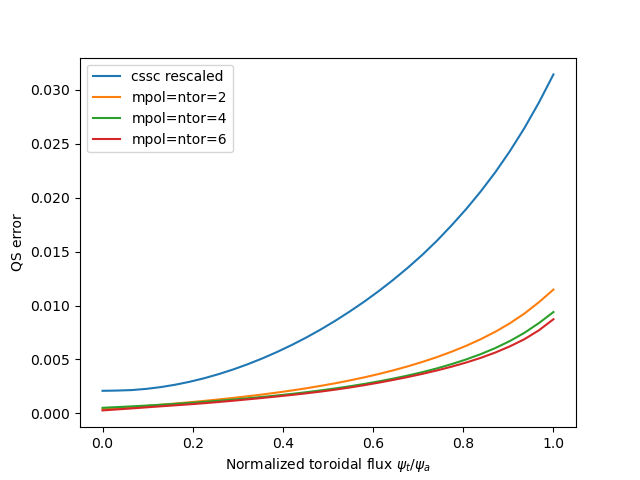

In [55]:
quasisymmetry_target_surfaces = np.linspace(0,1,32,endpoint=True)
plt.figure()
leg = ['cssc rescaled', 'mpol=ntor=2', 'mpol=ntor=4', 'mpol=ntor=6']
for v, l in zip(varr,leg):
    qs = QuasisymmetryRatioResidual(v, quasisymmetry_target_surfaces, helicity_m=1, helicity_n=0)
    plt.plot(quasisymmetry_target_surfaces, qs.profile(), label=l)
plt.legend()
plt.xlabel(r'Normalized toroidal flux $\psi_t/\psi_a$')
plt.ylabel('QS error')

plt.savefig(os.path.join(figure_path, 'qs_profile.png'))

In [57]:
bs = load('flux_100_bs_cssc_cssc.json')

/Users/antoinebaillod/Github/simsopt/src/simsopt/geo/curve.py:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


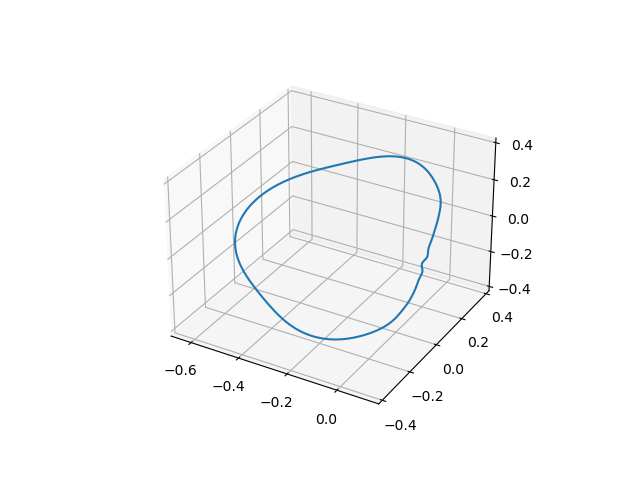

<Axes3D: >

In [58]:
bs.coils[0].plot()